# Cleaning and Visualizing Food Insecurity Dataset

Food security information can be found on the Humanitarian Data Exchange (https://data.humdata.org/dataset/somalia-acute-food-insecurity-country-data). The excel file lists the percent and number of people in each region in various phases of food insecurity at different time stamps, as well as projected food insecurity (again, by region, #/%, and by phase). The exel file is not easy to analyze as-is so this jupyter notebook is meant to ingest the file and turn it into a dictionary of pandas dataframes for analysis and visualizations. A few examples of visualizations are also included.

## Data Ingestion

In [1]:
# basics and accesing data
#import pathlib
import os
import io
import zipfile
import pandas as pd
import requests
import psycopg2
import numpy as np

# accessing data from HDX with API
from hdx.utilities.easy_logging import setup_logging
from hdx.api.configuration import Configuration
from hdx.data.dataset import Dataset

# quick visualization and analysis
from matplotlib import pyplot as plt
#import numpy as np
#import seaborn as sns

# mapping
import geopandas as geo #may also need fiona and pyproj
import folium
import math

In [2]:
#Download data here: https://map.ipcinfo.org/api/public/population-tracking-tool/data/2017,2022/?export=true&condition=A&country=SO
# food insecurity data
fi = pd.read_excel('Data/Somalia - IPC Analysis 2017-2022.xlsx', skiprows = 9)
fi.drop(fi.tail(6).index,inplace=True)

#copy column titles for column name parts that span multiple columns
curr_cols = fi.columns.values
curr_cols
new_cols = curr_cols
curr_title = 'Geo Info'
for i in range(len(new_cols)):
    if 'Unnamed:' in new_cols[i]:
        new_cols[i] = curr_title
    else:
        curr_title = new_cols[i]
new_cols
fi.columns = curr_cols

#copy column titles for column name parts that span multiple columns
first_row = fi.iloc[0]
curr_firstRow = first_row.values

curr_title = 'Geo Info'
for i in range(len(curr_firstRow)):
    if 'nan' in str(curr_firstRow[i]):
        curr_firstRow[i] = curr_title
    else:
        curr_title = curr_firstRow[i]
curr_firstRow
fi.iloc[0] = curr_firstRow

#make multi-part column names
fi.columns = [fi.columns.values, fi.iloc[0].values, fi.iloc[1].values]
fi = fi.iloc[2:].reset_index(drop=True)
fi


Geo Info                             \
                                       Geo Info                              
                                        Country     Level 1 Name      Area   
0    Somalia: Acute Food Insecurity August 2022              NaN       NaN   
1                                         Awdal              NaN       NaN   
2                                        Bakool              NaN       NaN   
3                                       Banadir              NaN       NaN   
4                                          Bari              NaN       NaN   
..                                          ...              ...       ...   
934                                     Somalia         Togdheer    Sheikh   
935                             Woqooyi Galbeed              NaN       NaN   
936                                     Somalia  Woqooyi Galbeed   Berbera   
937                                     Somalia  Woqooyi Galbeed   Gebiley   
938                                     Somalia  Woqooyi Galbeed  Hargeysa   

                                                                    \
                                                                     
      Area ID                       Analysis Name Date of Analysis   
0         NaN                                 NaN         Aug 2022   
1         NaN                                 NaN         Aug 2022   
2         NaN                                 NaN         Aug 2022   
3         NaN                                 NaN         Aug 2022   
4         NaN                                 NaN         Aug 2022   
..        ...                                 ...              ...   
934  12693377  Acute Food Insecurity January 2017         Jan 2017   
935       NaN                                 NaN         Jan 2017   
936  12693318  Acute Food Insecurity January 2017         Jan 2017   
937  12693366  Acute Food Insecurity January 2017         Jan 2017   
938  12693375  Acute Food Insecurity January 2017         Jan 2017   

               Current                                                       \
              Geo Info Population Analysed                                    
    Country Population                   # % of total county Pop Area Phase   
0             16384726            16384726                     1        NaN   
1                  NaN              557046                   NaN        NaN   
2                  NaN              475838                   NaN        NaN   
3                  NaN             2777228                   NaN        NaN   
4                  NaN             1079082                   NaN        NaN   
..                 ...                 ...                   ...        ...   
934                NaN               75904                   NaN          2   
935                NaN             1242003                   NaN        NaN   
936                NaN              176008                   NaN          2   
937                NaN              106914                   NaN          2   
938                NaN              959081                   NaN          2   

     ... Second Projection                                              \
     ...           Phase 2      Phase 3      Phase 4      Phase 5        
     ...                 #    %       #    %       #    %       #    %   
0    ...               NaN  NaN     NaN  NaN     NaN  NaN     NaN  NaN   
1    ...               NaN  NaN     NaN  NaN     NaN  NaN     NaN  NaN   
2    ...               NaN  NaN     NaN  NaN     NaN  NaN     NaN  NaN   
3    ...               NaN  NaN     NaN  NaN     NaN  NaN     NaN  NaN   
4    ...               NaN  NaN     NaN  NaN     NaN  NaN     NaN  NaN   
..   ...               ...  ...     ...  ...     ...  ...     ...  ...   
934  ...               NaN  NaN     NaN  NaN     NaN  NaN     NaN  NaN   
935  ...               NaN  NaN     NaN  NaN     NaN  NaN     NaN  NaN   
936  ...               NaN  NaN     NaN  NaN

In [3]:
#break up table into tables for each time stamp

#for consistency between sections- add NaN row at first
fi1 = pd.DataFrame([[np.nan] * len(fi.columns)], columns=fi.columns)
fi =  fi1.append(fi, ignore_index=True)

col = fi.iloc[:, fi.columns.get_level_values(2)=='Date of Analysis']
fi_dict = {}
col_vals = col.values
col_vals = col_vals.astype(str)
a = np.where(col_vals == 'nan')
a = a[0]
curr_start = 0
a = a[1:]
for i in range(len(a)):
    curr_table = fi.iloc[curr_start:a[i]]
    fi_dict[curr_table.iloc[1][0]] = curr_table[1:]
    curr_start = a[i]

fi_dict.keys()

C:\Users\cle9a\AppData\Local\Temp\ipykernel_8412\825470944.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fi =  fi1.append(fi, ignore_index=True)


dict_keys(['Somalia: Acute Food Insecurity August 2022', 'Somalia: Acute Food Insecurity May 2022', 'Somalia: Acute Food Insecurity March 2022 (Proj. Update)', 'Somalia: Acute Food Insecurity January 2022', 'Somalia: Acute Food Insecurity August 2021', 'Somalia: Acute Food Insecurity January 2021', 'Somalia: Acute Food Insecurity August 2020', 'Somalia: Acute Food Insecurity January 2020', 'Somalia: Acute Food Insecurity August 2019', 'Somalia: Acute Food Insecurity January 2019', 'Somalia: Acute Food Insecurity July 2018', 'Somalia: Acute Food Insecurity January 2018', 'Somalia: Acute Food Insecurity July 2017'])

In [4]:
#admin 1 options
example = fi_dict['Somalia: Acute Food Insecurity August 2020']
a = example.iloc[:, example.columns.get_level_values(2)=='Country']
print(np.unique(a.values))
#admin 2 options
a = example.iloc[:, example.columns.get_level_values(2)=='Area']
print(np.unique(a.values.astype(str)))
#column titles
for i in example.columns:
    print(i)

['Awdal' 'Bakool' 'Banadir' 'Bari' 'Bay' 'Galgaduud' 'Gedo' 'Hiraan'
 'Juba Dhexe' 'Juba Hoose' 'Mudug' 'Nugaal' 'Sanaag' 'Shabelle Dhexe'
 'Shabelle Hoose' 'Somalia' 'Somalia: Acute Food Insecurity August 2020'
 'Sool' 'Togdheer' 'Woqooyi Galbeed']
['Adan yabaal' 'Afgooye' 'Afmadow' 'Baardheere' 'Badhaadhe' 'Baki'
 'Balcad' 'Banadir' 'Bandarbeyla' 'Baraawe' 'Baydhaba' 'Belet weyne'
 'Belet xaawo' 'Berbera' 'Borama' 'Bossaso' "Bu'aale" 'Bulo burto' 'Burco'
 'Burtinle' 'Buuhoodle' 'Buur hakaba' 'Cabudwaaq' 'Cadaado' 'Cadale'
 'Caluula' 'Caynabo' 'Ceel afweyn' 'Ceel barde' 'Ceel buur' 'Ceel dheer'
 'Ceel waaq' 'Ceerigaabo' 'Dhuusamarreeb' 'Diinsoor' 'Doolow' 'Eyl'
 'Gaalkacyo' 'Galdogob' 'Garbahaarey' 'Garoowe' 'Gebiley' 'Hargeysa'
 'Hobyo' 'Iskushuban' 'Jalalaqsi' 'Jamaame' 'Jariiban' 'Jilib' 'Jowhar'
 'Kismaayo' 'Kurtunwaarey' 'Laas caanood' 'Laasqoray' 'Lughaye' 'Luuq'
 'Marka' 'Owdweyne' 'Qandala' 'Qansax dheere' 'Qardho' 'Qoryooley'
 'Rab dhuure' 'Saakow' 'Sablaale' 'Sheikh' 'Taleex

## Time Series

In [5]:
def showtimeseries(fi_dict, loc, admin, proj, phase, data_type):
    all_vals = []
    for i in range(len(loc)):
        vals = []
        time = []
        for k in fi_dict.keys():
            curr = fi_dict[k]
            if admin[i] == 1:
                curr = curr[(curr.loc[:, 'Geo Info'].loc[:,'Geo Info'].loc[:,'Country'] == loc[i]) & (curr.loc[:, 'Geo Info'].loc[:,'Geo Info'].loc[:,'Area'].isnull())]
            elif admin[i] == 2:
                curr = curr[curr.loc[:, 'Geo Info'].loc[:,'Geo Info'].loc[:,'Area'] == loc[i]]
            curr2 = curr.iloc[:, ((curr.columns.get_level_values(0)==proj) & (curr.columns.get_level_values(1)==phase) & (curr.columns.get_level_values(2)==data_type))]
            if not curr2.values:
                vals.append(np.nan)
            else:
                vals.append(curr2.values[0][0])
            time.append(k.rsplit(" ")[4]+" "+k.rsplit(" ")[5])
        time = time[::-1]
        vals = vals[::-1]
        all_vals.append(vals)
    all_vals = np.transpose(all_vals)
    plt.plot(time, all_vals)
    plt.ylabel(data_type)
    plt.xlabel('time')
    plt.xticks(rotation=45)
    plt.title(proj+ ' '+phase)
    plt.legend(loc)
    return vals, time

C:\Users\cle9a\AppData\Local\Temp\ipykernel_8412\2343829479.py:13: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if not curr2.values:


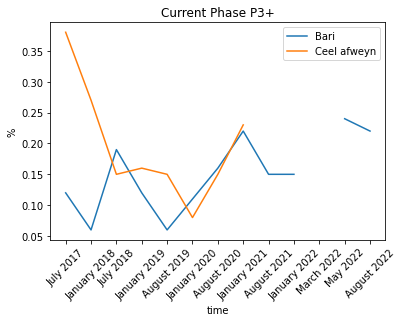

In [6]:
loc = ['Bari', 'Ceel afweyn']
admin = [1,2]
proj = 'Current'
phase = 'Phase P3+'
data_type = '%'

vals, time = showtimeseries(fi_dict, loc, admin, proj, phase, data_type)

C:\Users\cle9a\AppData\Local\Temp\ipykernel_8412\2343829479.py:13: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if not curr2.values:


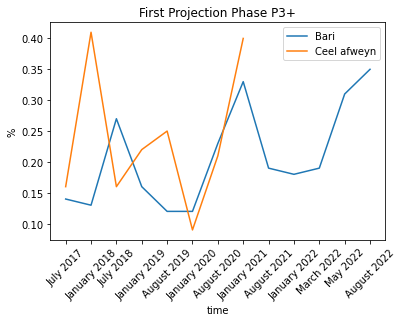

In [7]:
vals, time = showtimeseries(fi_dict, loc, admin, 'First Projection', phase, data_type)

## Maps

In [8]:
#get map data from here:https://data.humdata.org/dataset/ec140a63-5330-4376-a3df-c7ebf73cfc3c/resource/6f42e9ce-bbca-4c0d-a3e6-85efc9298c3c/download/som-administrative-divisions-shapefiles.zip
is_shp = lambda string: string.endswith('shp')
URL2 = 'https://data.humdata.org/dataset/ec140a63-5330-4376-a3df-c7ebf73cfc3c/resource/6f42e9ce-bbca-4c0d-a3e6-85efc9298c3c/download/som-administrative-divisions-shapefiles.zip'
response = requests.get(URL2)
z = zipfile.ZipFile(io.BytesIO(response.content))
folder = "admin"
z.extractall()
shapes = []
for filename in os.listdir(folder):
    f = os.path.join(folder, filename)
    # checking if it is a file
    if is_shp(f):
        shapes.append(geo.read_file(f))
        
#will use second level of admin boundaries in mapping later on
gdf_admin1 = shapes[1]
gdf_admin2 = shapes[2]
gdf_admin2

OBJECTID_1 admin2Name admin2Pcod admin2RefN admin2AltN admin2Al_1  \
0            1    Banadir     SO2201    Banadir       None       None   
1            2     Borama     SO1101     Borama    Boorama       None   
2            3       Baki     SO1102       Baki       None       None   
3            4    Lughaye     SO1103    Lughaye       None       None   
4            5     Zeylac     SO1104     Zeylac     Saylac       None   
..         ...        ...        ...        ...        ...        ...   
69          70     Saakow     SO2703     Saakow      Sakow       None   
70          71   Kismaayo     SO2801   Kismaayo    Kismayo       None   
71          72    Afmadow     SO2802    Afmadow       None       None   
72          73  Badhaadhe     SO2803  Badhaadhe   Badhadhe       None   
73          74    Jamaame     SO2804    Jamaame     Jamame       None   

     admin1Name admin1Pcod admin0Name admin0Pcod        date     validOn  \
0       Banadir       SO22    Somalia         SO  2014-06-06  2017-04-05   
1         Awdal       SO11    Somalia         SO  2014-06-06  2017-04-05   
2         Awdal       SO11    Somalia         SO  2014-06-06  2017-04-05   
3         Awdal       SO11    Somalia         SO  2014-06-06  2017-04-05   
4         Awdal       SO11    Somalia         SO  2014-06-06  2017-04-05   
..          ...        ...        ...        ...         ...         ...   
69  Middle Juba       SO27    Somalia         SO  2014-06-06  2017-04-05   
70   Lower Juba       SO28    Somalia         SO  2014-06-06  2017-04-05   
71   Lower Juba       SO28    Somalia         SO  2014-06-06  2017-04-05   
72   Lower Juba       SO28    Somalia         SO  2014-06-06  2017-04-05   
73   Lower Juba       SO28    Somalia         SO  2014-06-06  2017-04-05   

   ValidTo  Shape_Leng  Shape_Area  \
0     None    0.864205    0.019619   
1     None    2.403698    0.254798   
2     None    2.871573    0.282360   
3     None    2.334272    0.275737   
4     None    3.852047    0.499583   
..     ...         ...         ...   
69    None    3.868911    0.654011   
70    None    5.532878    0.749813   
71    None    5.871596    2.174108   
72    None    4.657717    0.793048   
73    None    1.825811    0.175052   

                                             geometry  
0   POLYGON ((45.61720 2.18585, 45.61871 2.18601, ...  
1   POLYGON ((43.35094 10.05094, 43.33094 9.84096,...  
2   POLYGON ((44.23660 10.47312, 44.15096 10.32091...  
3   POLYGON ((44.07241 10.59786, 43.46094 10.38091...  
4   MULTIPOLYGON (((43.46797 11.42739, 43.45518 11...  
..                                                ...  
69  POLYGON ((42.95330 1.48243, 42.23090 1.51171, ...  
70  MULTIPOLYGON (((42.03180 -1.01986, 42.02406 -1...  
71  POLYGON ((41.00146 -0.19648, 40.99565 -0.19731...  
72  MULTIPOLYGON (((41.92670 -1.16192, 41.92260 -1...  
73  POLYGON ((42.72680 0.32868, 42.73091 0.31182, ...  

[74 rows x 16 columns]

In [9]:
#get Phase 3+ for all time/admin2 locs
proj = 'Current'
phase = 'Phase P3+'
data_type = '%'

gdf_admin2_map = gdf_admin2.copy()
for k in fi_dict.keys():
    curr = fi_dict[k]
    curr2 = curr.iloc[:,((curr.columns.get_level_values(0)=='Geo Info') & 
                       (curr.columns.get_level_values(1)=='Geo Info') & 
                       (curr.columns.get_level_values(2)=='Area')) |
                      ((curr.columns.get_level_values(0)==proj) & 
                       (curr.columns.get_level_values(1)==phase) & 
                       (curr.columns.get_level_values(2)==data_type))]
    curr2 = curr2[~curr2['Geo Info']['Geo Info']['Area'].isnull()]
    curr2.columns = ['Area', k]
    gdf_admin2_map = gdf_admin2_map.merge(curr2, how ='left', left_on = 'admin2Name', right_on = 'Area' ).drop(columns = ['Area'])
    
#make map of current Phase 3+ over time
m = folium.Map(location=[5.1521, 46.1996], zoom_start=6 , tiles=None, zoom_control = False)
#create base map
base_map = folium.FeatureGroup(name='Basemap', overlay=True)
folium.TileLayer(tiles='cartodbpositron').add_to(base_map)
base_map.add_to(m)

#make label info
toolTip = {}
toolTip['l'] = ['admin2Name']

    
#make layers
layers = fi_dict.keys()
for l in layers:
    print(l)
    # plot chorpleth over the base map
    cp = folium.Choropleth(gdf_admin2_map,                                # geo data
                      data=gdf_admin2_map,                           # data
                      key_on='feature.properties.admin2Name',
                      columns=['admin2Name', l],
                      fill_color='RdPu',                     # cmap
                      line_weight=0.1,                       # line wight (of the border)
                      line_opacity=0.5,                      # line opacity (of the border)
                      overlay = False,
                      legend_name = l,
                      name =  l
                      ).add_to(m)    # name on the legend color bar
    folium.GeoJsonPopup(toolTip['l']+[l]).add_to(cp.geojson) #add information for each geoid

    
# add layer controls
folium.LayerControl().add_to(m)
m.save("admin2_overtime.html")
#not sure how to remove legends
m

Somalia: Acute Food Insecurity August 2022
Somalia: Acute Food Insecurity May 2022
Somalia: Acute Food Insecurity March 2022 (Proj. Update)
Somalia: Acute Food Insecurity January 2022
Somalia: Acute Food Insecurity August 2021
Somalia: Acute Food Insecurity January 2021
Somalia: Acute Food Insecurity August 2020
Somalia: Acute Food Insecurity January 2020
Somalia: Acute Food Insecurity August 2019
Somalia: Acute Food Insecurity January 2019
Somalia: Acute Food Insecurity July 2018
Somalia: Acute Food Insecurity January 2018
Somalia: Acute Food Insecurity July 2017


In [10]:
#get Phase 3+ for all time/admin2 locs
proj = 'Current'
phase = 'Phase P3+'
data_type = '%'

gdf_admin1_map = gdf_admin1.copy()
for k in fi_dict.keys():
    curr = fi_dict[k]
    curr2 = curr.iloc[:,((curr.columns.get_level_values(0)=='Geo Info') & 
                       (curr.columns.get_level_values(1)=='Geo Info') & 
                       (curr.columns.get_level_values(2)=='Country')) |
                      ((curr.columns.get_level_values(0)==proj) & 
                       (curr.columns.get_level_values(1)==phase) & 
                       (curr.columns.get_level_values(2)==data_type))]
    curr2 = curr2[~curr2['Geo Info']['Geo Info']['Country'].isnull()]
    curr2.columns = ['Area', k]
    gdf_admin1_map = gdf_admin1_map.merge(curr2, how ='left', left_on = 'admin1Name', right_on = 'Area' ).drop(columns = ['Area'])
    
#make map of current Phase 3+ over time
m = folium.Map(location=[5.1521, 46.1996], zoom_start=6 , tiles=None, zoom_control = False)
#create base map
base_map = folium.FeatureGroup(name='Basemap', overlay=True)
folium.TileLayer(tiles='cartodbpositron').add_to(base_map)
base_map.add_to(m)

#make label info
toolTip = {}
toolTip['l'] = ['admin1Name']

    
#make layers
layers = fi_dict.keys()
for l in layers:
    print(l)
    # plot chorpleth over the base map
    cp = folium.Choropleth(gdf_admin1_map,                                # geo data
                      data=gdf_admin1_map,                           # data
                      key_on='feature.properties.admin1Name',
                      columns=['admin1Name', l],
                      fill_color='RdPu',                     # cmap
                      line_weight=0.1,                       # line wight (of the border)
                      line_opacity=0.5,                      # line opacity (of the border)
                      overlay = False,
                      legend_name = l,
                      name =  l
                      ).add_to(m)    # name on the legend color bar
    folium.GeoJsonPopup(toolTip['l']+[l]).add_to(cp.geojson) #add information for each geoid

    
# add layer controls
folium.LayerControl().add_to(m)
m


Somalia: Acute Food Insecurity August 2022
Somalia: Acute Food Insecurity May 2022
Somalia: Acute Food Insecurity March 2022 (Proj. Update)
Somalia: Acute Food Insecurity January 2022
Somalia: Acute Food Insecurity August 2021
Somalia: Acute Food Insecurity January 2021
Somalia: Acute Food Insecurity August 2020
Somalia: Acute Food Insecurity January 2020
Somalia: Acute Food Insecurity August 2019
Somalia: Acute Food Insecurity January 2019
Somalia: Acute Food Insecurity July 2018
Somalia: Acute Food Insecurity January 2018
Somalia: Acute Food Insecurity July 2017


In [12]:
#make map of current projection of different phases
curr = fi_dict['Somalia: Acute Food Insecurity August 2022']
curr2 = curr.iloc[:,((curr.columns.get_level_values(0)=='Geo Info') & 
                       (curr.columns.get_level_values(1)=='Geo Info') & 
                       (curr.columns.get_level_values(2)=='Country')) |
                      ((curr.columns.get_level_values(0)=='Current') & 
                       (curr.columns.get_level_values(2)=='%'))]
curr2 = curr2[~curr2['Geo Info']['Geo Info']['Country'].isnull()]
phases = ['Phase 1', 'Phase 2', 'Phase 3', 'Phase 4', 'Phase 5','Phase P3+']
curr2.columns = ['Area']+phases
gdf_admin1_map = gdf_admin1.merge(curr2, how ='left', left_on = 'admin1Name', right_on = 'Area' ).drop(columns = ['Area'])
gdf_admin1_map

#make map of current Phase 3+ over time
m = folium.Map(location=[5.1521, 46.1996], zoom_start=6 , tiles=None, zoom_control = False)
#create base map
base_map = folium.FeatureGroup(name='Basemap', overlay=True)
folium.TileLayer(tiles='cartodbpositron').add_to(base_map)
base_map.add_to(m)

#make label info
toolTip = {}
toolTip['l'] = ['admin1Name']+phases

    
#make layers
for l in phases:
    print(l)
    # plot chorpleth over the base map
    cp = folium.Choropleth(gdf_admin1_map,                                # geo data
                      data=gdf_admin1_map,                           # data
                      key_on='feature.properties.admin1Name',
                      columns=['admin1Name', l],
                      fill_color='RdPu',                     # cmap
                      line_weight=0.1,                       # line wight (of the border)
                      line_opacity=0.5,                      # line opacity (of the border)
                      overlay = False,
                      legend_name = l,
                      name =  l
                      ).add_to(m)    # name on the legend color bar
    folium.GeoJsonPopup(toolTip['l']+[l]).add_to(cp.geojson) #add information for each geoid

    
# add layer controls
folium.LayerControl().add_to(m)
m.save("admin1_phases.html")
m

Phase 1
Phase 2
Phase 3
Phase 4
Phase 5
Phase P3+
